## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [122]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from torch.utils.data import Subset
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [5]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100.0%


Extracting fmnist\FashionMNIST\raw\train-images-idx3-ubyte.gz to fmnist\FashionMNIST\raw



100.0%


Extracting fmnist\FashionMNIST\raw\train-labels-idx1-ubyte.gz to fmnist\FashionMNIST\raw



100.0%


Extracting fmnist\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to fmnist\FashionMNIST\raw



100.0%

Extracting fmnist\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to fmnist\FashionMNIST\raw



In [125]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

overfit_train_loader = torch.utils.data.DataLoader(Subset(fmnist_dataset_train, torch.arange(15000)),
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [126]:
print(len(fmnist_dataset_train))
print(len(fmnist_dataset_test))
print(len(overfit_train_loader.dataset))


60000
10000
15000


torch.Size([128, 1, 28, 28])


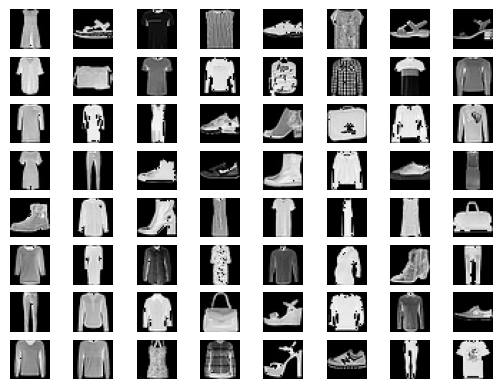

torch.Size([128])
128


In [19]:
def show_imgs(imgs, rows=8, cols=8):
    for x in range(rows):
        for y in range(cols):
            idx = y * rows + x
            plt.subplot(rows, cols, idx + 1)
            plt.imshow((256 * imgs[idx][0]).numpy().reshape((28, 28)).astype('uint8'), cmap='gray')
            plt.axis('off')
    plt.show()
    pass

for img, label in train_loader:
    print(img.shape)
    show_imgs(img)
    print(label.shape)
    print(label.size(0))
    break

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [99]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 300),
            nn.ReLU(),
            nn.BatchNorm1d(300),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, num_classes),
            nn.Softmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [103]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
              ReLU-3                  [-1, 300]               0
            Linear-4                  [-1, 100]          30,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
           Softmax-7                   [-1, 10]               0
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.02
Estimated Total Size (MB): 1.03
----------------------------------------------------------------


In [131]:
from time import time

def accuracy(predictions, labels):
    acc = torch.sum(torch.eq(input=torch.argmax(predictions, dim=1), other=labels))
    return acc / len(labels)

def train(net, n_epoch, train_loader, test_loader, optimizer, criterion, acc_break = 1.0):
    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []

    start = time()
    for i in range(n_epoch):
        net.train(True)
        total_loss = 0.0
        total_acc = 0.0
        iters = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            predictions = net.forward(imgs)
            loss = criterion(predictions, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_acc += accuracy(predictions, labels)
            iters += 1
        net.train(False)
        train_loss_history.append(total_loss / iters)
        train_acc_history.append(total_acc / iters)

        with torch.no_grad():
            total_loss = 0.0
            total_acc = 0.0
            iters = 0
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                predictions = net.forward(imgs)
                loss = criterion(predictions, labels)
                total_loss += loss.item()
                total_acc += accuracy(predictions, labels)
                iters += 1

            mean_loss = total_loss / iters
            mean_acc = total_acc / iters
            test_loss_history.append(mean_loss)
            test_acc_history.append(mean_acc)
            print(f'#{i + 1}/{n_epoch} epoch loss: {round(mean_loss, 7)}, acc: {mean_acc} ({train_acc_history[-1]})', end='\r')
            if (mean_acc >= acc_break):
                print(f"\nReached accuracy {mean_acc}! Breaking.\n")
                break

    # print("\n", end='')
    return time() - start, \
           train_loss_history, \
           train_acc_history, \
           test_loss_history, \
           test_acc_history


Your experiments come here:

In [104]:
net = TinyNeuralNetwork().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=4e-4)
criterion = nn.CrossEntropyLoss()
n_epoch = 50

time_tiny, train_loss_tiny, train_acc_tiny, test_loss_tiny, test_acc_tiny = \
    train(net, n_epoch, train_loader, test_loader, optimizer, criterion, 0.885)

print(f"\nTime elapsed: {round(time_tiny, 1)} s")

#39/50 epoch loss: 1.5767136, acc: 0.8851562738418579
Reached accuracy 0.8851562738418579! Breaking.


Time elapsed: 285.5 s


__Комментарий:__ Мне удалось обучить нейросеть до такого уровня точности без дропаута ~~с божей помощью~~, но без батчнорма не получилось: совсем без регуляризации сеть переобучается и не хочет достигать такой точности.

In [111]:
import seaborn as sns

# Эта функция сглаживает колебания и берет логарифм от полученного результата
def preproc(arr, alpha=0.9):
    processed = []
    old = 0.0
    for t in arr:
        new = t * (1.0 - alpha) + old * alpha
        processed.append(new)
        old = new

    return np.log(processed)


sns.set(style="darkgrid", font_scale=1.4)

def build_plot(title: str,
               train_loss,
               test_loss,
               train_acc,
               test_acc,
               ylim_acc=[0.0, 1.0],
               alpha=0.0):
    fig = plt.figure(figsize=(16, 9))
    ax1, ax2 = fig.subplots(1, 2)
    fig.suptitle(title)

    ax1.set_title("Потери")
    ax1.set_ylabel("LogLoss")
    ax1.set_xlabel("Эпоха")
    ax1.plot(preproc(train_loss, alpha=alpha), label='Train set')
    ax1.plot(preproc(test_loss, alpha=alpha), label='Test set')
    ax1.legend()

    ax2.set_title("Точность")
    ax2.set_ylabel("Accuracy")
    ax2.set_xlabel("Эпоха")
    ax2.plot(train_acc, label='Train set')
    ax2.plot(test_acc, label='Test set')
    ax2.set_ylim(ylim_acc)
    ax2.legend()
    plt.show()

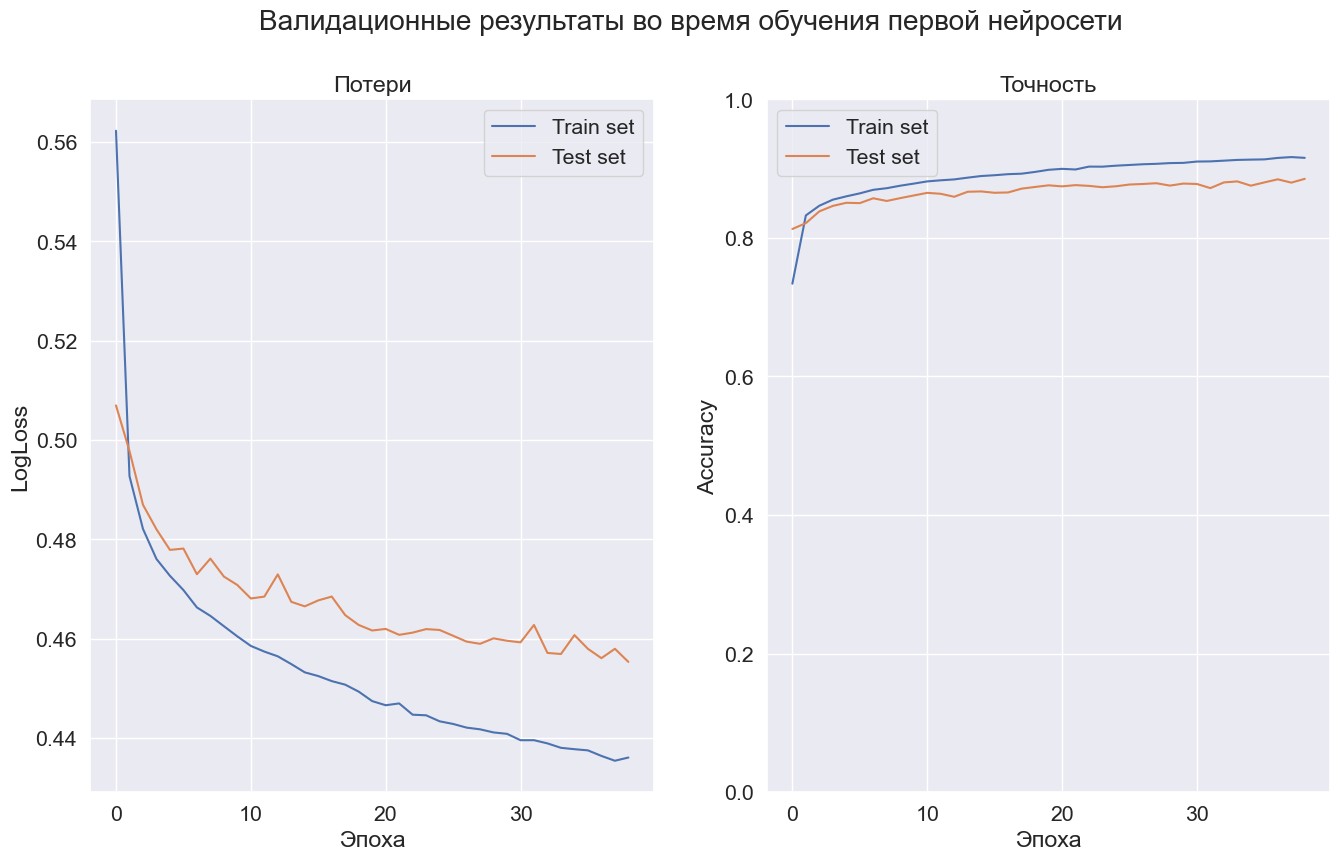

In [112]:
build_plot("Валидационные результаты во время обучения первой нейросети",
           train_loss_tiny, test_loss_tiny, train_acc_tiny, test_acc_tiny)

__Комментарий:__ видно, что переобучение не наступает, потому что лосс падает и точность растет одновременно на обоих наборах данных.

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [142]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1500),
            nn.ReLU(),
            # Регуляризация не нужна
            nn.Linear(1500, 1000), # Больше непонятных нейронов!!
            nn.ReLU(),
            # И здесь тоже регуляризация не нужна
            nn.Linear(1000, 1500),  # Еще один слой
            nn.ReLU(),
            # Кому нужна регуляризация
            nn.Linear(1500, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out


In [143]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1500]       1,177,500
              ReLU-3                 [-1, 1500]               0
            Linear-4                 [-1, 1000]       1,501,000
              ReLU-5                 [-1, 1000]               0
            Linear-6                 [-1, 1500]       1,501,500
              ReLU-7                 [-1, 1500]               0
            Linear-8                   [-1, 10]          15,010
           Softmax-9                   [-1, 10]               0
Total params: 4,195,010
Trainable params: 4,195,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 16.00
Estimated Total Size (MB): 16.07
-------------------------------------

In [140]:
overfit_net = OverfittingNeuralNetwork().to(device)
optimizer = torch.optim.Adam(overfit_net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
n_epoch = 30

time_overfit, train_loss_overfit, train_acc_overfit, test_loss_overfit, test_acc_overfit = \
    train(overfit_net, n_epoch, overfit_train_loader, test_loader, optimizer, criterion)

print(f"\nTime elapsed: {round(time_overfit, 1)} s")

KeyboardInterrupt: 

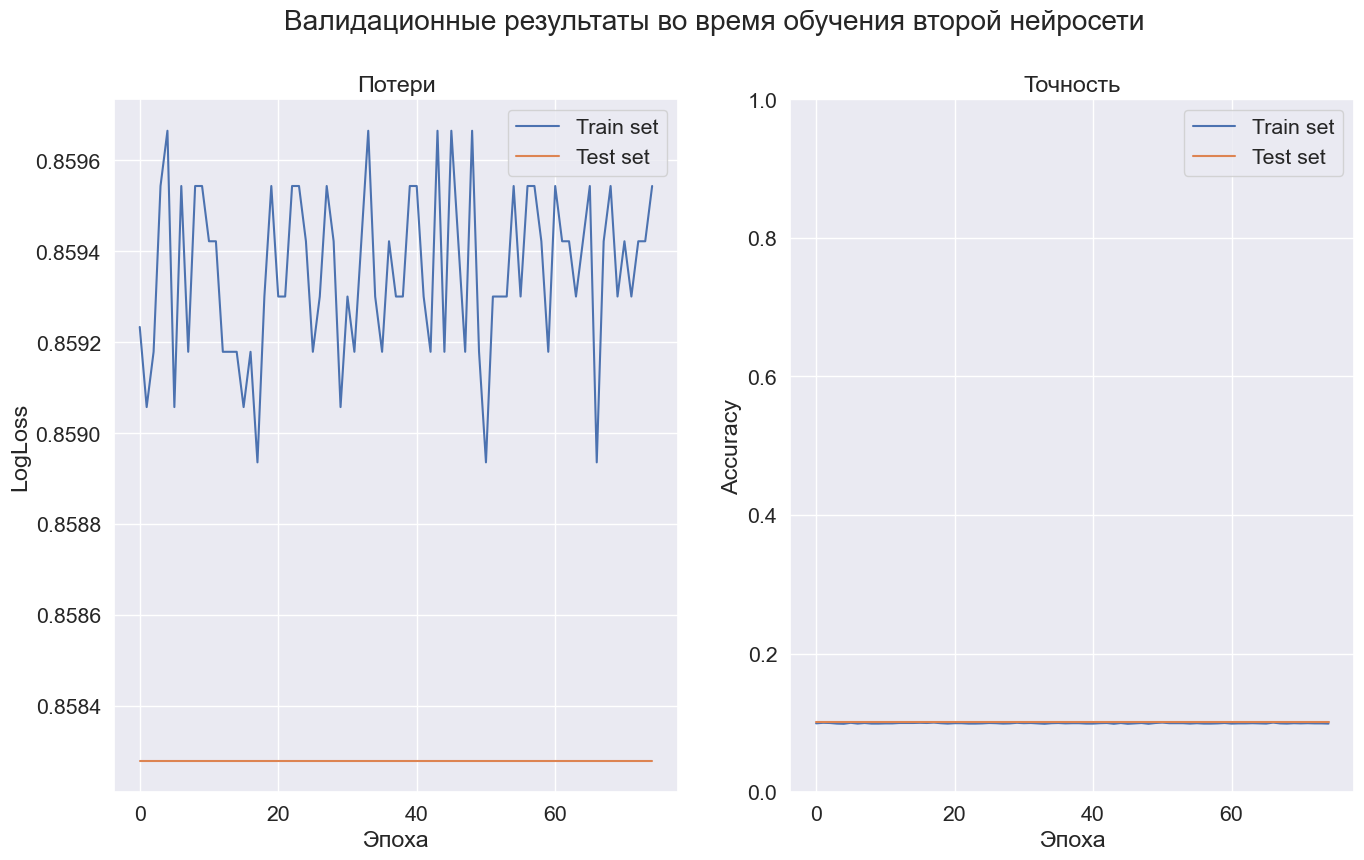

In [141]:
build_plot("Валидационные результаты во время обучения второй нейросети",
           train_loss_overfit, test_loss_overfit, train_acc_overfit, test_acc_overfit)


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

In [ ]:
model = FixedNeuralNetwork().to(device)
opt = # YOUR CODE HERE
loss_func = # YOUR CODE HERE

# Your experiments, come here

### Conclusions:
_Write down small report with your conclusions and your ideas._